In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import sys
import os
import json

Loading the data

In [2]:
def load_tsp_file(file_path):
    tsp_data = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Flag to indicate the start of the NODE_COORD_SECTION
    start_loading = False

    for line in lines:
        # Strip leading and trailing whitespaces
        line = line.strip()

        # Check for the start of the NODE_COORD_SECTION
        if line == "NODE_COORD_SECTION":
            start_loading = True
            continue

        # Check for the end of the file
        if line == "EOF":
            break

        if start_loading:
            parts = line.split()
            
            # Extract node number, x-coordinate, and y-coordinate
            node_number = int(parts[0])
            x_coordinate = float(parts[1])
            y_coordinate = float(parts[2])

            # Store data in the dictionary
            tsp_data[node_number] = np.array([x_coordinate, y_coordinate])

    # Check if the dataset is as intuitive as it appears
    nodes = set(tsp_data.keys())
    highest_number = max(nodes)
    missing_nodes = set(range(1, highest_number + 1)) - nodes

    if missing_nodes:
        print(f"Note that not all numbers between 0 and {highest_number} are used as a node ID. Node(s) {missing_nodes} are missing.")

    return tsp_data

In [3]:
def custom_serialize(obj):
    """
    Returns the name of a function
    """
    if callable(obj):
        return obj.__name__
    return obj

def custom_deserialize(obj):
    """
    Returns the function corresponding to the function name provided
    """
    if '__name__' in obj:
        return globals()[obj]
    return obj


Generate random initial solution

In [87]:
def generate_solution(tsp_data):
    # Make random order as a starting solution
    return np.random.permutation(list(tsp_data.keys()))


def generate_greedy_solution(tsp_data, distance_matrix):
    # Initialize an empty route
    route = []
    
    # Start at the first city
    current_city = list(tsp_data.keys())[0]
    route.append(current_city)
    
    # Create a mask to keep track of visited cities
    visited_mask = np.zeros(len(tsp_data), dtype=bool)
    visited_mask[current_city - 1] = True
    
    # Continue searching for the next neighbor until all cities are visited
    while len(route) < len(tsp_data):
        # Get the index of the current city
        current_index = current_city - 1
        
        # Get the row of distances for the current city
        distances = distance_matrix[current_index]
        
        # Apply the visited mask to exclude already visited cities
        distances[visited_mask] = np.inf
        
        # Find the unvisited neighbor with the minimum distance
        next_city = np.argmin(distances) + 1
        
        # Add the next city to the route
        route.append(next_city)
        
        # Mark the next city as visited
        visited_mask[next_city - 1] = True
        
        # Move to the next city
        current_city = next_city
    
    return route

Calculate score

In [108]:
def calculate_distance_matrix(tsp_data):
    coordinates = np.array(list(tsp_data.values()))
    distance_matrix = np.linalg.norm(coordinates[:, np.newaxis, :] - coordinates[np.newaxis, :, :], axis=-1)
    
    return distance_matrix

In [202]:
def get_score(distance_matrix, solution):
    # Calculate distance of a solution using the precomputed distance matrix
    from_cities = np.array(solution[:-1]) - 1
    to_cities = np.array(solution[1:]) - 1
    
    total_distance = np.sum(distance_matrix[from_cities, to_cities])
    
    return total_distance

Mutation operators

In [7]:
def swap(solution, iteration):
    # Randomly choose two distinct indices
    indices = np.random.choice(len(solution), size=2, replace=False)

    new_solution = solution.copy()

    # Swap the elements at the selected indices
    new_solution[indices[0]], new_solution[indices[1]] = new_solution[indices[1]], new_solution[indices[0]]

    return new_solution


def inversion(solution, iteration):
    n = len(solution)

    # Choose two distinct indices for the inversion
    start, end = np.random.choice(n, size=2, replace=False)
    start, end = min(start, end), max(start, end)

    # Perform inversion
    new_solution = solution.copy()
    new_solution[start:end + 1] = np.flip(new_solution[start:end + 1])

    return new_solution


def insert(solution, iteration):
    n = len(solution)

    # Choose two distinct indices for the insertion
    source_index, dest_index = np.random.choice(n, size=2, replace=False)

    # Ensure source_index is before dest_index
    source_index, dest_index = min(source_index, dest_index), max(source_index, dest_index)

    # Perform insertion
    moved_element = solution[source_index]
    new_solution = np.delete(solution, source_index)
    new_solution = np.insert(new_solution, dest_index, moved_element)

    return new_solution


def two_opt(solution, iteration):
    """ Given a TSP route called solution and the current iteration of the algorithm,
    switches the next possible pair of nodes and returns the corresponding route """

    # Get number of nodes
    n = len(solution)

    # Get the number of total pairs
    total_pairs = int(n * (n-1) / 2)

    # Get index of current pair of nodes to consider
    start =  (iteration % total_pairs) // (n-1)
    end =  (iteration % total_pairs) % (n-1)

    start, end = min(start, end), max(start, end)

    new_solution = solution.copy()
    new_solution[start:end + 1] = np.flip(new_solution[start:end + 1])

    # Return the new route
    return new_solution



# Didn't work properly so changed it to function above
def old_two_opt(solution, iteration):
    """ Given a TSP route called solution and the current iteration of the algorithm,
    switches the next possible pair of nodes and returns the corresponding route """

    # Get number of nodes
    n = len(solution)

    # Get the number of total pairs
    total_pairs = int(n * (n-1) / 2)

    # Get index of current pair of nodes to consider
    index_1 =  (iteration % total_pairs) // (n-1)
    index_2 =  (iteration % total_pairs) % (n-1)

    # Adjust index_2 if it is equal to or greater than index_1
    if index_2 >= index_1:
        index_2 += 1

    # Get current pair to swap
    node_1 = solution[index_1]
    node_2 = solution[index_2]

    # Invert the route between them
    a = solution[0:node_1+1]
    b = solution[node_1+1:node_2+1]
    b = b[::-1]
    c = solution[node_2+1:]
    new_solution = np.concatenate([a,b,c])

    # Return the new route
    return new_solution

Acceptance operators

In [8]:
def hillclimber(current_score, new_score, T):
    # Hillclimber function, accept only better scores
    return current_score > new_score

def simulated_annealing(current_score, new_score, T):
    return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)

Cooling schemes

In [9]:
def logarithmic_cool(iterations, cooling_parameters):
    i = np.arange(iterations) + 1
    return cooling_parameters['c'] / np.log(1 + i)


def linear_cool(iterations, cooling_parameters):
    i = np.arange(iterations)
    Ts = cooling_parameters['initial'] - cooling_parameters['slope'] * i
    return np.where(Ts < 0, 0, Ts)


def arithmetic_geometric_cool(iterations, cooling_parameters):
    T = cooling_parameters['initial']
    Ts = np.zeros(iterations)

    for i in range(iterations):
        T = T * cooling_parameters['alpha'] + cooling_parameters['beta']
        Ts[i] = T
    
    return Ts


def exponential_cool(iterations, cooling_parameters):
    i = np.arange(iterations)
    return cooling_parameters['initial'] * cooling_parameters['alpha']**i


def quadratic_cool(iterations, cooling_parameters):
    i = np.arange(iterations)
    return cooling_parameters['initial'] / (1 + cooling_parameters['alpha'] * i**2)

Main optimizing function

In [137]:
def optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule=logarithmic_cool, cooling_parameters={'c':1}, stopping_point=0.05, save_progress=False):
    """
    Optimize solution for traveling salesman problem according to chosen mutate and accept function
    """ 

    solution = start_solution[:]
    current_score = get_score(distance_matrix, solution)

    Ts = cooling_schedule(iterations, cooling_parameters)

    iterations_without_improvement = 0
    stopping_point *= iterations

    scores = {}

    # Do iterations
    for i in range(iterations):

        # Make new solution via chosen mutation function
        new_solution = mutate(solution, i)
        new_score = get_score(distance_matrix, new_solution)

        # Accept or deny new solution according to chosen acceptance function and corresponding parameters
        if accept(current_score, new_score, Ts[i]):
            solution = new_solution[:]
            current_score = new_score
            iterations_without_improvement = 0

            if save_progress:
                scores[i] = new_score
            
        else:
            iterations_without_improvement += 1
            if iterations_without_improvement == stopping_point:
                return solution, current_score, scores

    return solution, current_score, scores

Tuning functions for cooling schemes

In [186]:
def tune_logarithmic_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    c = trial.suggest_float('c', 0.001, 1000)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix)
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, logarithmic_cool, {'c': c})[1] / runs
        
    return result

def tune_linear_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.01, 10000)
    slope = trial.suggest_float('slope', 0., 10)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix)
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, linear_cool, {'initial': initial, 'slope': slope})[1] / runs
        
    return result

def tune_arithmetic_geometric_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.001, 10000)
    alpha = trial.suggest_float('alpha', 0., 1)
    beta = trial.suggest_float('beta', 0., 100)

    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix)
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, arithmetic_geometric_cool, {'initial': initial, 'alpha': alpha, 'beta': beta})[1] / runs
        
    return result

def tune_exponential_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.001, 1000)
    alpha = trial.suggest_float('alpha', 0., 1)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix)
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, exponential_cool, {'initial': initial, 'alpha': alpha})[1] / runs
        
    return result

def tune_quadratic_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    initial = trial.suggest_float('initial', 0.001, 10000)
    alpha = trial.suggest_float('alpha', 0., 1)
    result = 0
    for run in range(runs):
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix)
        else:
            start_solution = generate_solution(tsp_data)
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, quadratic_cool, {'initial': initial, 'alpha': alpha})[1] / runs
        
    return result

Main tuning function

In [206]:
def tune(tsp_data, distance_matrix, tuning_runs, n_trials, iterations, mutations, cooling_schedules, file_path=None, greedy=True):
    """
    Tunes parameters of all combinations of the provided cooling schedules and mutations for a set number of iterations, and stores them in as a JSON file
    """

    if file_path:
        if os.path.exists(file_path):
            print(f"Error: The file '{file_path}' already exists. Please choose a different file name.")
            sys.exit(1)
            
    accept = simulated_annealing
    print_status = False

    all_cooling_parameters = {}
    if not print_status:
        optuna.logging.set_verbosity(optuna.logging.WARNING)

    for mutate in mutations:
        cooling_parameters = {}

        for cooling_schedule in cooling_schedules:
            
            cooling_scheme = cooling_schedule.__name__
            study = optuna.create_study()
            study.optimize(lambda trial: globals()['tune_' + cooling_scheme](trial, tsp_data, distance_matrix, tuning_runs, iterations, mutate, accept, greedy=greedy), n_trials=n_trials)
            cooling_parameters[cooling_scheme] = {'cooling_schedule': cooling_schedule, 'cooling_parameters': study.best_params}

        all_cooling_parameters[mutate.__name__] = cooling_parameters
    
    if file_path:
        with open(file_path, 'w') as file:
            json.dump(all_cooling_parameters, file, default=custom_serialize, indent=2)

    return all_cooling_parameters


def global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy, fileID=''):
    """
    Runs the tuning function for all files and different amounts of iterations
    """
    for file in files:
        file_path = f'TSP-Configurations/{file}.tsp.txt'
        tsp_data = load_tsp_file(file_path)
        distance_matrix = calculate_distance_matrix(tsp_data)

        for iterations in iterations_list:
            tune(tsp_data, distance_matrix, tuning_runs, n_trials, iterations, mutations, cooling_schedules, file_path=f'{fileID}best_parameters_{file}_{iterations}_iterations.json', greedy=greedy)

In [13]:
def load_cooling_info(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file, object_hook=custom_deserialize)

    for item in data.values():
        for subitem in item.values():
            cooling = subitem['cooling_schedule']
            subitem['cooling_schedule'] = globals()[cooling]
    return data

Plot cooling behaviour. Didn't show what we hoped for so might just delete it

In [220]:
def investigate_cooling(iterations, cooling_schedule, cooling_parameters, title, percentage=None, difference=None, num_datapoints=None, ax=None, logx=False, logy=False):
    Ts = cooling_schedule(iterations, cooling_parameters)
    
    if num_datapoints is not None and num_datapoints > iterations:
        stride = max(1, iterations // num_datapoints)
    else:
        stride = 1

    if ax is None:
        fig, ax = plt.subplots()

    if percentage:
        differences = Ts * np.log(percentage)
        ax.plot(np.arange(iterations)[::stride], differences[::stride], label=f'{iterations} iterations')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Setback')
        ax.set_title(f"Setback which will be accepted with {percentage}% chance with {title}")


    if difference:
        percentages = np.exp(-1 * abs(difference)/Ts)
        ax.plot(np.arange(iterations)[::stride], percentages[::stride], label=f'{iterations} iterations')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Acceptance probability')
        ax.set_title(f"Acceptance probabilities of {title} with a setback of {abs(difference)}")

    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')

Compare performance of all different algorithm combinations with a given set of mutations and cooling schedules

In [128]:
def compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules, accept=simulated_annealing, plot_results=True, print_results=True, set_title=False, greedy=True):
    results = []
    for cooling_schedule in cooling_schedules:
        cooling_results = []
        
        for mutate in mutations:
            scores = []
            parameters = all_cooling_parameters[mutate.__name__][cooling_schedule.__name__]
            for run in range(N_runs):

                if greedy:
                    start_solution = generate_greedy_solution(tsp_data, distance_matrix)
                else:
                    start_solution = generate_solution(tsp_data)
                    
                score = optimize(start_solution, distance_matrix, iterations, mutate, accept, **parameters)[1]
                scores.append(score)

            cooling_results.append({'mutation function': mutate.__name__,'scores': scores , 'average': np.mean(scores), 'std': np.std(scores)})

        results.append({'cooling schedule': cooling_schedule.__name__, 'data': cooling_results})
    

    if not(print_results or plot_results):
        return results

    bar_width = 0.1
    bar_positions = np.arange(len(mutations))
    mutation_names = [func.__name__ for func in mutations]
    cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']


    for i, result in enumerate(results):
        if print_results:
            print(f"\n\n{cooling_schemes[i]}:\n")
            print("%-40s %-20s" % ("Mutation Function", "Results"))

        if plot_results:
            bar_results = []
            bar_stds = []

        for data in result['data']:
            average = data['average']
            std = data['std']

            if plot_results:
                bar_results.append(average)
                bar_stds.append(std)

            if print_results:
                mutation_function = data['mutation function']
                score_with_std = "%.4f (+/- %.4f)" % (average, std)
                print("%-40s %-15s" % (mutation_function, score_with_std))
        if plot_results:
            plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], align='center')

    if plot_results:
        title_addition = ''
        if set_title:
            title_addition = f' with {iterations} iterations'
        plt.xlabel('Mutation Functions')
        plt.ylabel('Scores')
        plt.title(f'Performance of all algorithm combinations{title_addition}')
        plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
        plt.grid()
        # plt.legend()

        plt.tight_layout()
        plt.show()


Load the best parameters from the json files where the tuning stored them, for all different numbers of iterations, and compare the performance of all given algorithm combinations. 

In [208]:
def compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID=''):
    for iterations in iterations_list:
        all_cooling_parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')

        mutations = list(all_cooling_parameters.keys())
        cooling_schedules = list(all_cooling_parameters[mutations[0]].keys())
        
        mutations = [globals()[mutation] for mutation in mutations]
        cooling_schedules = [globals()[cooling_schedule] for cooling_schedule in cooling_schedules]

        results = compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules, print_results=False, set_title=True, greedy=greedy)
        
    # fig, ax = plt.subplots()

    # im = ax.imshow(data, cmap='viridis', interpolation='nearest')

    # x_gridlines = np.arange(-0.5, 19.5, 5)
    # y_gridlines = np.arange(-0.5, 6.5)

    # for x in x_gridlines:
    #     ax.axvline(x=x, color='black', linestyle='-', linewidth=3)

    # for y in y_gridlines:
    #     ax.axhline(y=y, color='black', linestyle='-', linewidth=3)

    # xlabels = ['Swap', 'Insert', 'Inversion', '2-opt']
    # ax.set_xticks(x_gridlines + 2.5)
    # ax.set_xticklabels(xlabels, fontsize=8)
    # ax.tick_params(axis='x', which='major', pad=-115)

    # additional_xticks = np.arange(1, 21) - 0.9
    # additional_labels = ['Logarithmic', 'Linear', 'Arithmetic-Geometric', 'Exponential', 'Quadratic'] * 4
    # ax.set_xticks(additional_xticks, minor=True)
    # ax.set_xticklabels(additional_labels, rotation=75, minor=True, fontsize=8)


    # ylabels = ['10000', '5000', '1000', '500', '100', '50', '10']
    # ax.set_yticks(y_gridlines + 0.5, ylabels)

    # cbar = plt.colorbar(im, ax=ax)
    # cbar.set_label('Score')

    # plt.xlabel('Algorithm')
    # plt.ylabel('Iterations')

    # plt.show()

Open a file, and tune the parameters for all different algorithm combinations.

Be advised, might take a while!

In [225]:
files = ['eil51', 'a280', 'pcb442']
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [swap, insert, inversion, two_opt]

iterations_list = [5000, 10000]
tuning_runs = 5
n_trials = 100

global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy=False, fileID='random_')

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


Compare results of the global tuning just done

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


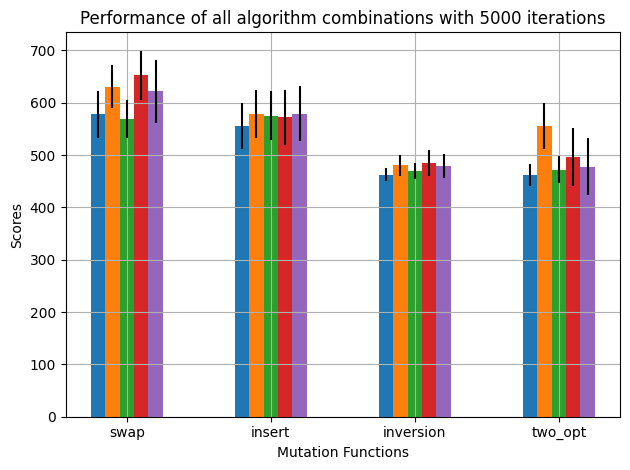

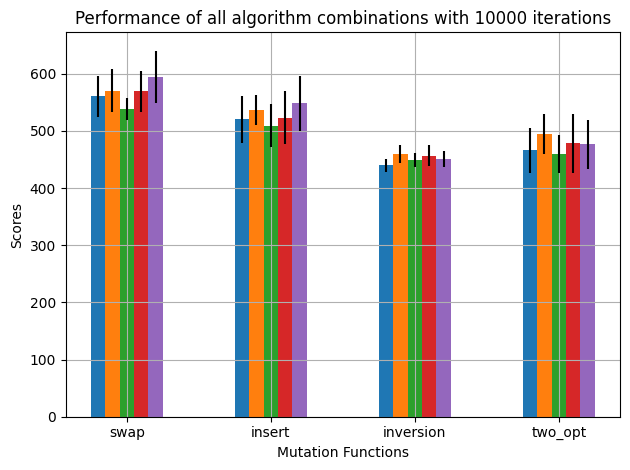

In [209]:
N_runs = 20
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [5000, 10000]
compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=False, fileID='zzz_')

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


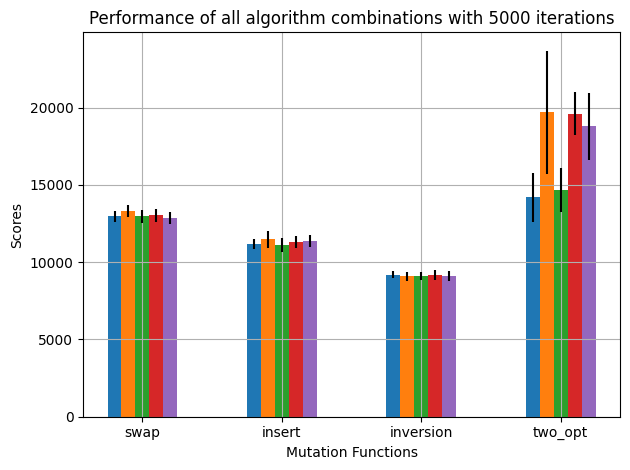

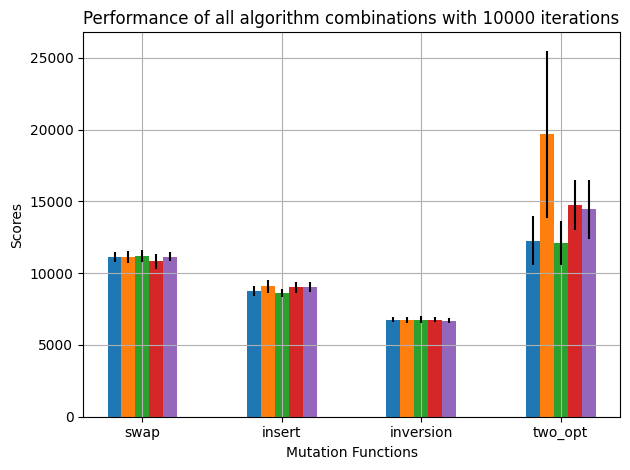

In [210]:
N_runs = 20
file = 'a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [5000, 10000]
compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=False, fileID='zzz_')

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


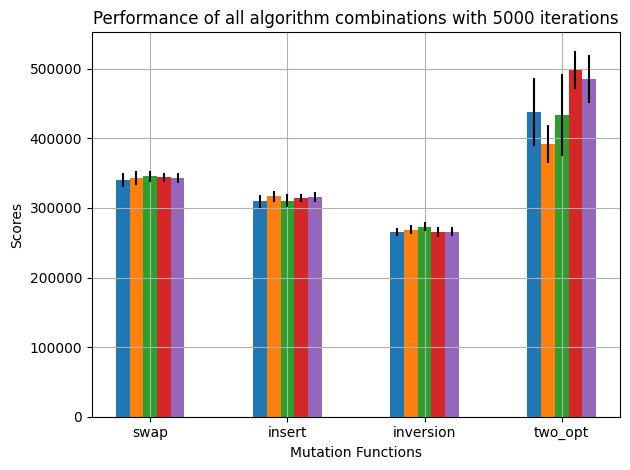

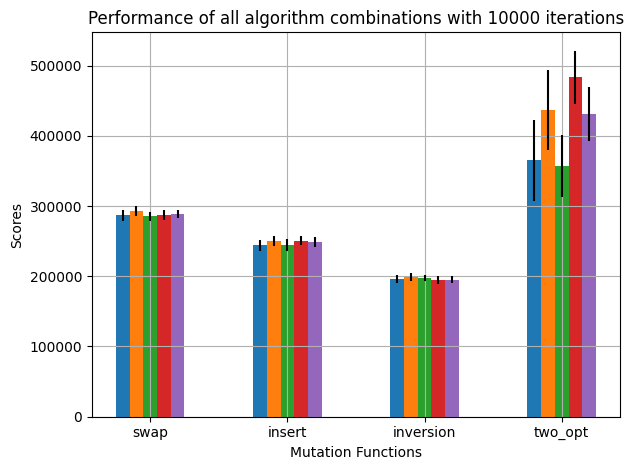

In [203]:
N_runs = 20
file = 'pcb442'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [5000, 10000]
compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=False, fileID='zzz_')

In [214]:
files = ['eil51', 'a280', 'pcb442']
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [swap, insert, inversion, two_opt]

iterations_list = [5000, 10000]
tuning_runs = 5
n_trials = 100

global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy=True, fileID='greedy2_')

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


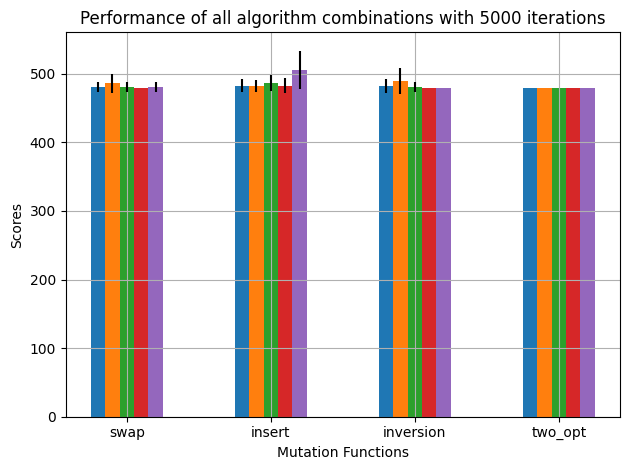

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


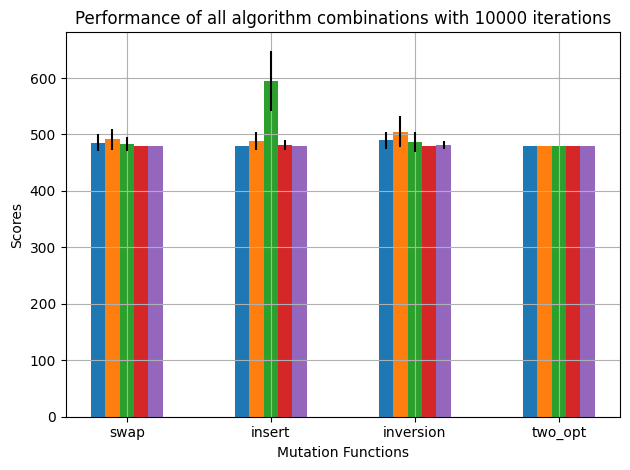

In [215]:
N_runs = 20
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [5000, 10000]
compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID='greedy2_')

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


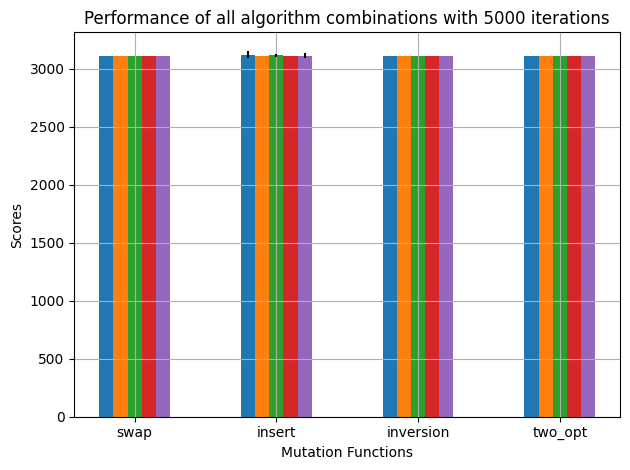

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


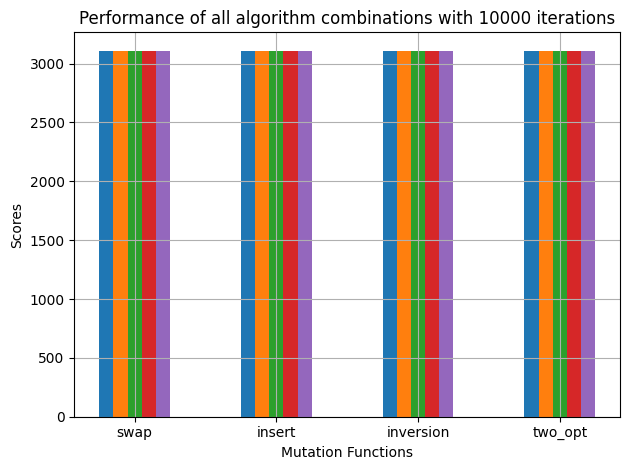

In [216]:
N_runs = 20
file = 'a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [5000, 10000]
compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID='greedy_')

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


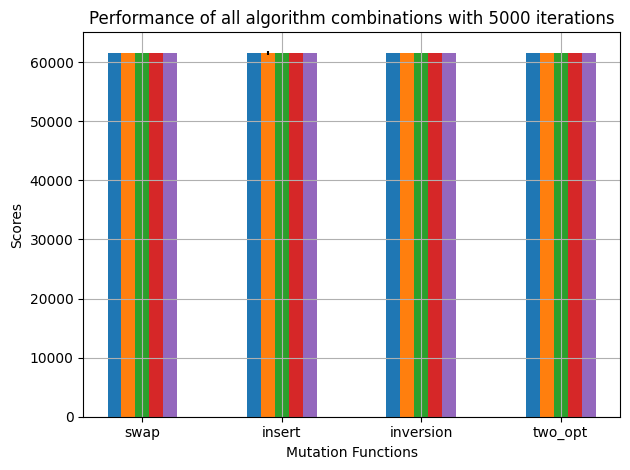

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


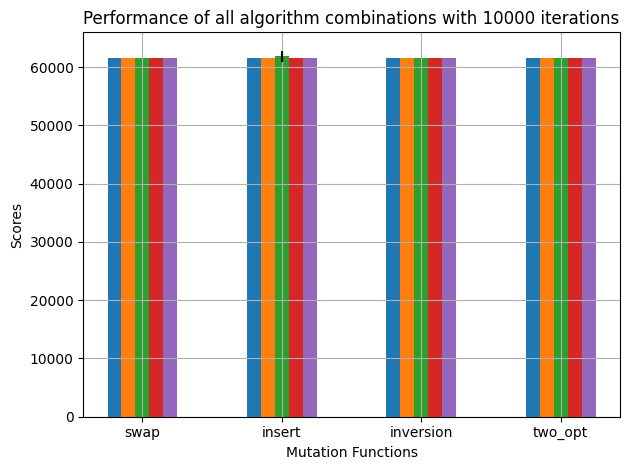

In [217]:
N_runs = 20
file = 'pcb442'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [5000, 10000]
compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, greedy=True, fileID='greedy_')

In [38]:
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations = 10000
tuning_runs = 5
n_trials = 50

parameters = tune(tsp_data, distance_matrix, tuning_runs, n_trials, iterations, mutations, cooling_schedules, print_results=False, greedy=True)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


In [184]:
N_runs = 10
file='a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)

distance_matrix = calculate_distance_matrix(tsp_data)
cooling_parameters = load_cooling_info(f'new_best_parameters_{file}_{100000}_iterations.json')
#parameters = load_cooling_info(f'best_parameters_{file}_{10000}_iterations.json')

mutate = inversion
cooling_schedule = linear_cool
accept = simulated_annealing

parameters = {
    'initial': 50,
    'slope': 0.0005,
}

iterations = 10000000

start_solution = generate_solution(tsp_data)
solution, score, scores = optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule, parameters, stopping_point=0.05, save_progress=True)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_7840\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


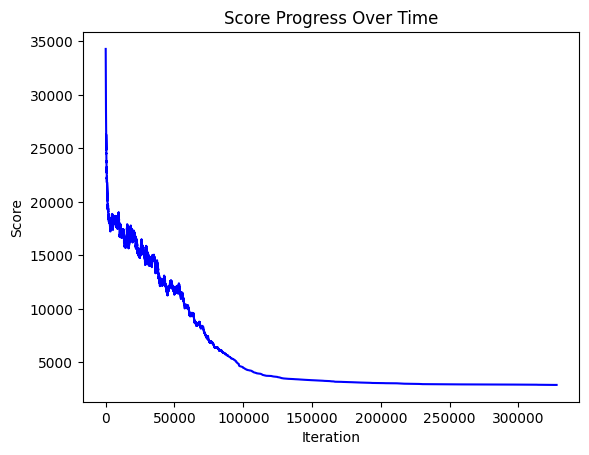

2888.408238977952


In [185]:
iterations = list(scores.keys())
new_scores = list(scores.values())

# Interpolate the data to get a continuous line
interp_iterations = np.arange(min(iterations), max(iterations) + 1)
interp_scores = np.interp(interp_iterations, iterations, new_scores)

# Create a line plot
plt.plot(interp_iterations, interp_scores, linestyle='-', color='b')

# Set plot labels and title
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Score Progress Over Time')

# Display the plot
plt.show()

print(score)

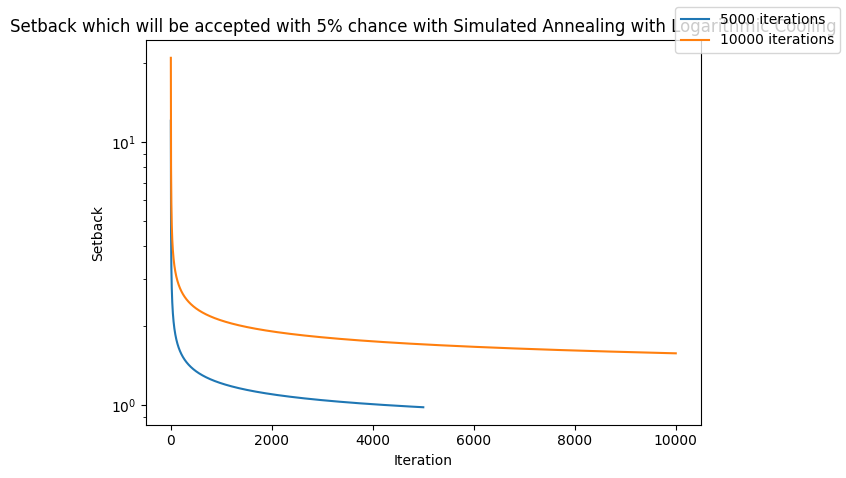

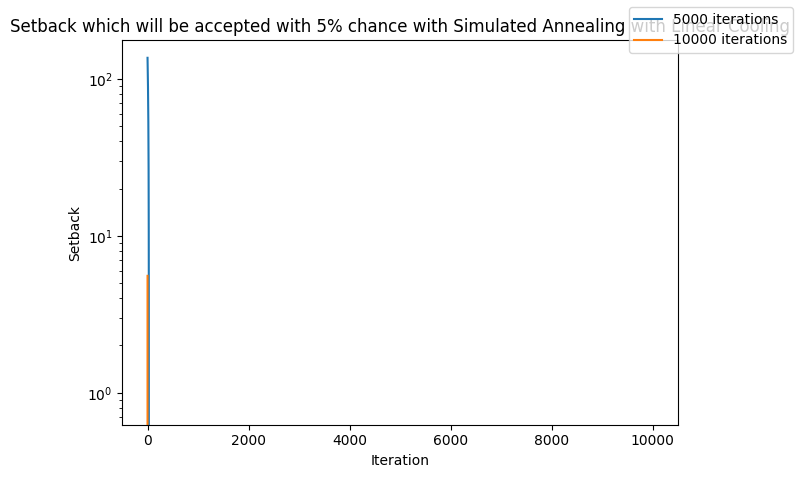

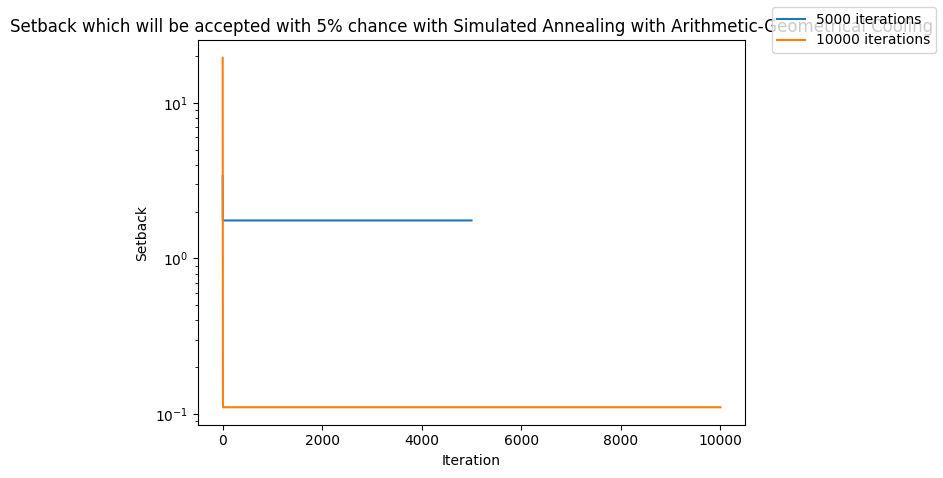

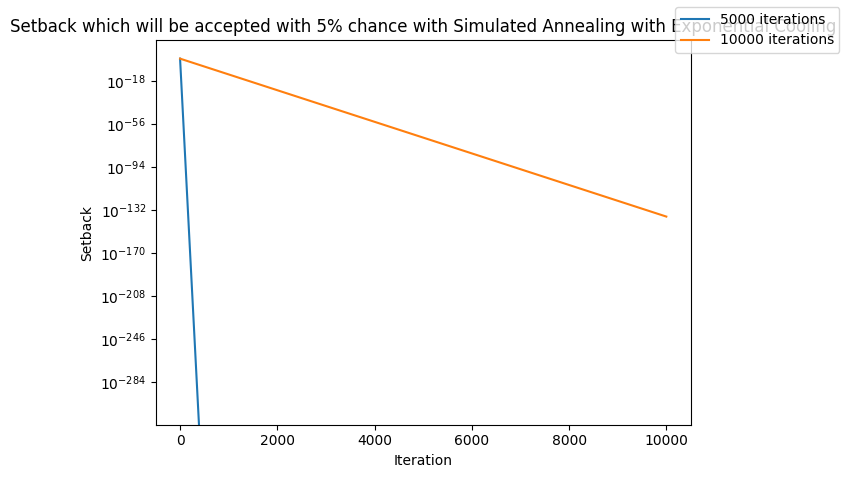

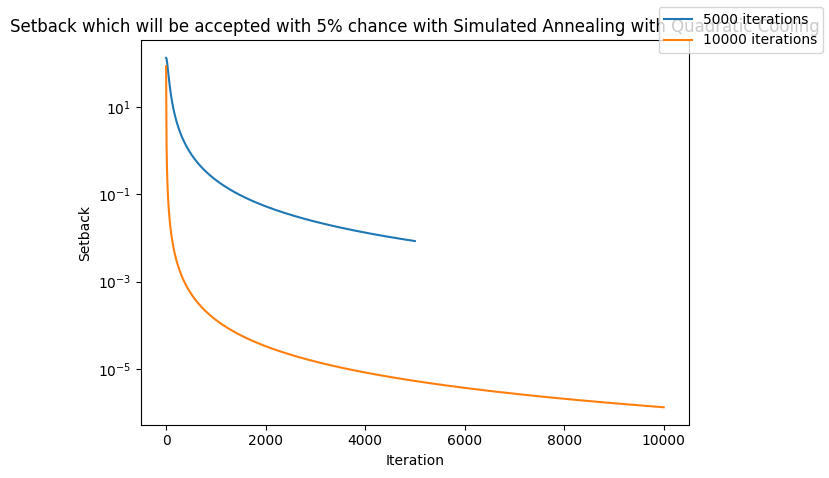

In [223]:
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling', 'Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [inversion]
iterations_list = [5000, 10000]
difference = None
percentage = 5
file = 'a280'
fileID = ''

for mutate in mutations:
    for i, cooling_schedule in enumerate(cooling_schedules):
        
        fig, ax = plt.subplots(1)
        for iterations in iterations_list:
            all_cooling_parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
            parameters = all_cooling_parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']

            investigate_cooling(iterations, cooling_schedule, parameters, cooling_schemes[i], percentage=percentage, difference=difference, num_datapoints=50, ax=ax, logx=False, logy=True)

        fig.legend()
        fig.tight_layout()
        plt.show()

Show performance

In [ ]:
N_runs = 20
iterations = 1000
results = compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules)

work in progress for next blocks

C:\Users\jaspe\AppData\Local\Temp\ipykernel_31328\480169370.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_31328\480169370.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_31328\480169370.py:6: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_31328\480169370.py:6: RuntimeWarning: overflow encountered in exp
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)




Simulated Annealing with Logarithmic Cooling:

Mutation Function                        Results             
inversion                                3689.8332 (+/- 57.9835)


Simulated Annealing with Linear Cooling:

Mutation Function                        Results             
inversion                                3744.3457 (+/- 19.2849)


Simulated Annealing with Arithmetic-Geometrical Cooling:

Mutation Function                        Results             
inversion                                3555.0312 (+/- 3.9278)


Simulated Annealing with Exponential Cooling:

Mutation Function                        Results             
inversion                                3724.7421 (+/- 36.2275)


Simulated Annealing with Quadratic Cooling:

Mutation Function                        Results             
inversion                                34646.1505 (+/- 2.8886)


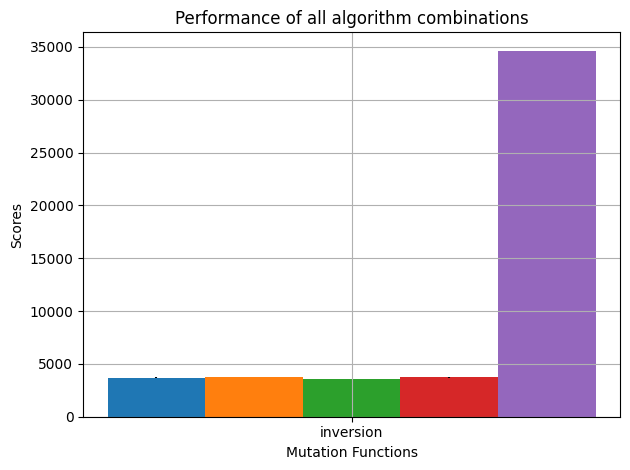

In [ ]:
file = 'a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)

N_runs = 2
iterations = 50000
all_cooling_parameters = load_cooling_info('inversion_best_parameters_a280_50000_iterations.json')
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [inversion]

compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules)